# Reproducing NeurIPS2019 - Subspace Attack

As part of the NeurIPS2019 reproducibility challenge (project 2 of EPFL CS-433 2019) we chose to reproduce the paper [__Subspace Attack: Exploiting Promising Subspaces for Query-Efficient Black-box Attacks__](https://openreview.net/pdf?id=S1g-OVBl8r)

The algorithm is specified in: 

<img src="img/algo1.png" style="width:600px;"/>

We need to create the following functions:
- Load random reference model
- Loss function calculation
- Prior gradient calculation wrt dropout/layer ratio
- Attack

The pre-trained models are in (https://drive.google.com/file/d/1aXTmN2AyNLdZ8zOeyLzpVbRHZRZD0fW0/view).
The least demanding target model is the __GDAS__.


__Note!__ we start with 0 droupout ratio.

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import torch
from torchvision import datasets, transforms
import numpy as np

from src.import_models import load_model, MODELS_DATA, MODELS_DIRECTORY
from src.plots import imshow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load MNIST dataset
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

data = datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)

Files already downloaded and verified


In [3]:
# Load reference models
reference_model_names = ['vgg11_bn', 'vgg13_bn', 'vgg16_bn', 'vgg16_bn', 'vgg19_bn', 'AlexNet_bn']
reference_models = list(map(lambda name: load_model(MODELS_DIRECTORY, MODELS_DATA, name, num_classes), reference_model_names))



# Load victim model
victim_model_name = 'gdas'
victim_model = load_model(MODELS_DIRECTORY, MODELS_DATA, victim_model_name, num_classes)
_ = victim_model.eval()

if torch.cuda.is_available():
    reference_models = list(map(lambda model: model.to('cuda'), reference_models))
    victim_model = victim_model.to('cuda')

Predicted: frog
Real: frog
1.0


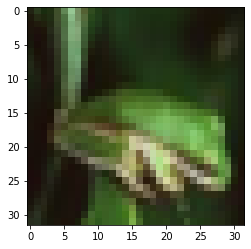

In [4]:
for data, target in data_loader:
    
    if torch.cuda.is_available():
        data = data.to('cuda')
        target = target.to('cuda')
    
    output = victim_model(data)
    
    label_index = output.max(1, keepdim=True)[1].item()
    
    print('Predicted: ' + classes[label_index])
    print('Real: ' + classes[target[0]])
    print(torch.nn.functional.softmax(output[0].max(), dim=0).item())
    
    imshow(data[0].cpu())
    
    break

In [5]:
def attack(input_batch, true_label, tau, epsilon, delta, eta_g, eta, victim, references, limit=10000 verbose=False, show_images=False):
    
    # Regulators
    regmin = input_batch - epsilon
    regmax = input_batch + epsilon

    # Initialize the adversarial example 
    x_adv = input_batch.clone()
    y = true_label

    # setting a example label

    criterion = torch.nn.CrossEntropyLoss()

    #Initialize the gradient to be estimated
    g = torch.zeros_like(input_batch) # check the dimensions

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        x_adv = x_adv.to('cuda')
        y = y.to('cuda')
        g = g.to('cuda')
        regmin = regmin.to('cuda')
        regmax = regmax.to('cuda')

    # initialize quiries counter
    q_counter = 0
    
    if show_images:
        with torch.no_grad():
            imshow(x_adv[0].cpu())

    success = False

    while not success and q_counter < limit:
        
        if q_counter % 50 == 0 and verbose:
            # imshow(x_adv[0].cpu())
            print(f'Iteration number: {str(q_counter / 2)}')
            print(f'{str(q_counter)} queries have been made')
        
        # Load random reference model
        random_model = random.randint(0, len(reference_models) - 1)
        model = references[random_model]
        model.eval()

        # calculate the prior gradient - L8
        x_adv.requires_grad_(True)

        model.zero_grad()
        output = model(x_adv)

        loss = criterion(output, y)

        loss.backward()

        u = x_adv.grad

        # Calculate delta - L11
        with torch.no_grad():
            # Calculate g_plus and g_minus - L9-10
            g_plus = g + tau * u
            g_minus = g - tau * u

            g_minus = g_minus / g_minus.norm()
            g_plus = g_plus / g_plus.norm()
            x_plus = x_adv + delta * g_plus
            x_minus = x_adv + delta * g_minus

            query_minus = victim(x_minus)
            query_plus = victim(x_plus)
        
        q_counter += 2        

        delta_t = ((criterion(query_plus, y) - criterion(query_minus, y)) / (tau * epsilon)) * u

        # Update gradient - L12
        g = g + eta_g * delta_t
        
        # Update the adverserial example - L13-15
        with torch.no_grad():
            x_adv = x_adv + eta * torch.sign(g)
            x_adv = torch.max(x_adv, regmin)
            x_adv = torch.min(x_adv, regmax)
            x_adv = torch.clamp(x_adv, 0, 1)
            
            # Check success
            label_minus = query_minus.max(1, keepdim=True)[1].item()
            label_plus = query_plus.max(1, keepdim=True)[1].item()

        if  label_minus != true_label.item() or label_plus != true_label.item():
            print('Success! after {} queries'.format(q_counter))
            print("True: {}".format(true_label.item()))
            print("Label minus: {}".format(label_minus))
            print("Label plus: {}".format(label_plus))
            if show_images:
                imshow(x_adv[0].cpu())
            success = True

    return q_counter if success else -1

In [20]:
# Hyper-parameters
tau = 0.1
epsilon = 8./255
delta = 1.0
eta_g = 100
eta = 0.1

counter = 0
limit = 10

queries = []

for data, target in data_loader:
    print(f'\n-------------\n')
    print(f'Target image number {counter}')
    
    queries_counter = attack(data, target, tau, epsilon, delta, eta_g, eta, victim_model, reference_models, verbose=True)
    
    counter += 1
    
    queries.append(queries_counter)
    
    if counter == limit:
        break


-------------

Target image number 0
Iteration number: 0.0
0 queries have been made
Iteration number: 25.0
50 queries have been made
Iteration number: 50.0
100 queries have been made
Iteration number: 75.0
150 queries have been made
Iteration number: 100.0
200 queries have been made
Iteration number: 125.0
250 queries have been made
Iteration number: 150.0
300 queries have been made
Iteration number: 175.0
350 queries have been made
Iteration number: 200.0
400 queries have been made
Iteration number: 225.0
450 queries have been made
Iteration number: 250.0
500 queries have been made
Iteration number: 275.0
550 queries have been made
Iteration number: 300.0
600 queries have been made
Iteration number: 325.0
650 queries have been made
Iteration number: 350.0
700 queries have been made
Iteration number: 375.0
750 queries have been made
Iteration number: 400.0
800 queries have been made
Iteration number: 425.0
850 queries have been made
Iteration number: 450.0
900 queries have been made
I

In [21]:
results = np.array(queries)
failed = results == -1
    
print(f'Mean number of queries: {results[~failed].mean()}')
print(f'Median number of queries: {np.median(results[~failed])}')
print(f'Number of failed queries: {len(results[failed])}')

Mean number of queries: 15.0
Median number of queries: 6.0
Number of failed queries: 2


# Attack implementation
28-11-2019: Dan

In [ ]:
import torch
from torchvision import datasets, transforms
from torchvision.models import vgg16
from PIL import Image

# Hyper-parameters
tau = 0.1
epsilon = 8./255
delta = 0.01
eta_g = 100
eta = 0.1


# loading true example
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

input_image = Image.open(filename)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225]),
    ])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# Regulators
regmin = input_batch - epsilon
regmax = input_batch + epsilon

# Initialize the adversarial example 
x_adv = input_batch

# setting a example label
true_label = 258
y = torch.tensor([true_label]).long()

criterion = torch.nn.CrossEntropyLoss()

#Initialize the gradient to be estimated
g = torch.zeros_like(input_batch) # check the dimensions


# load model
model = torch.hub.load('pytorch/vision:v0.4.2', 'vgg11', pretrained=True)
model.eval()

# load victem model
victim = torch.hub.load('pytorch/vision:v0.4.2', 'alexnet', pretrained=True)
victim.eval()

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    x_adv = x_adv.to('cuda')
    model = model.to('cuda')
    victim = victim.to('cuda')
    y = y.to('cuda')
    g = g.to('cuda')
    regmin = regmin.to('cuda')
    regmax = regmax.to('cuda')

# initialize quiries counter
q_counter = 0

with torch.no_grad():
    imshow(x_adv[0].cpu())

success = False

while not success and q_counter < 1000:
    print(q_counter)
    # Load model
    model = torch.hub.load('pytorch/vision:v0.4.2', 'vgg11', pretrained=True)
    model.eval()
    if torch.cuda.is_available():
        model = model.to('cuda')

    # calculate the prior gradient - L8
    x_adv.requires_grad_(True)

    model.zero_grad()
    output = model(x_adv)

    loss = criterion(output, y)

    loss.backward()

    u = x_adv.grad

    # Calculate g_plus and g_minus - L9-10
    g_plus = g + tau*u
    g_minus = g - tau*u

    g_minus = g_minus/g_minus.norm()
    g_plus = g_plus/g_plus.norm()

    # Calculate delta - L11
    with torch.no_grad():
        x_plus = x_adv + delta*g_plus
        x_minus = x_adv + delta*g_minus

    query_minus = victim(x_minus)
    query_plus = victim(x_plus)
    q_counter += 2

    print(torch.nn.functional.softmax(query_minus[0].max(), dim=0).item())
    print(torch.nn.functional.softmax(query_minus[0].max(), dim=0).item())

    delta_t = ((criterion(query_plus, y) - criterion(query_minus, y)) / (tau * epsilon)) * u

    # Update gradient - L12
    g = g + eta_g * delta_t
    # Update the adverserial example - L13-15
    with torch.no_grad():
        x_adv = x_adv + eta * torch.sign(g)
        x_adv = torch.max(x_adv, regmin)
        x_adv = torch.min(x_adv, regmax)
        x_adv = torch.clamp(x_adv, 0, 1)
        imshow(x_adv[0].cpu())

    # Check success
    label_minus = query_minus.max(1, keepdim=True)[1].item()
    label_plus = query_plus.max(1, keepdim=True)[1].item()

    if  label_minus != true_label or label_plus != true_label :
        print('Success! after {} queries'.format(q_counter))
        print("True: {}".format(true_label))
        print("Label minus: {}".format(label_minus))
        print("Label plus: {}".format(label_plus))
        success = True